In [1]:
# import glob

# for image_path in glob.glob(DATAFOLDER+"/Images/*/*"):
#     image_path = Path(image_path)
#     image_path.rename(image_path.with_suffix(".png"))

In [2]:
import numpy as np
import torch

import flash
from flash.image import SemanticSegmentation, SemanticSegmentationData
from flash.image import ImageClassifier

from matplotlib import pyplot as plt
import numpy as np

from pathlib import Path

torch.cuda.empty_cache()

In [3]:
# Set the datafolder here
DATAFOLDER = "../../task-1-data-preprocessing/Annotations_Segmentation__Masks/segmentation__mask_batch-1"
# IMAGES_FOLDER = Path(DATAFOLDER) / "images"
# SEGMENTATIONS_FOLDER = Path(DATAFOLDER) / "annotations-segmentation-masks"
TRAIN_FILES_TXT = Path(DATAFOLDER) / "train.txt"
TEST_FILES_TXT = Path(DATAFOLDER) / "test.txt"

In [4]:
# Here are the available heads we can use
SemanticSegmentation.available_heads()

['deeplabv3',
 'deeplabv3plus',
 'fpn',
 'linknet',
 'manet',
 'pan',
 'pspnet',
 'unet',
 'unetplusplus']

In [5]:
# Here is the available pre-trained backbone we can use
ImageClassifier.available_backbones()

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dino_deits16',
 'dino_deits8',
 'dino_vitb16',
 'dino_vitb8',
 'dla102',
 

In [6]:
# Get the list of files of training images and masks

train_files = []
train_targets = []

with open(TRAIN_FILES_TXT, "r") as f:
    for filepath in f.readlines():
        train_files.append(Path(DATAFOLDER) / "Images" / Path(filepath.replace("\n","")+".png"))
        train_targets.append(Path(DATAFOLDER) / "SegmentationClassMask" / Path(filepath.replace("\n","")+".png"))


In [7]:
# Get the list of files of testing images and masks

test_files = []
test_targets = []

with open(TEST_FILES_TXT, "r") as f:
    for filepath in f.readlines():
        test_files.append(Path(DATAFOLDER) / "Images" / Path(filepath.replace("\n","")+".png"))
        test_targets.append(Path(DATAFOLDER) / "SegmentationClassMask" / Path(filepath.replace("\n","")+".png"))


In [8]:
test_files

[PosixPath('../../task-1-data-preprocessing/Annotations_Segmentation__Masks/segmentation__mask_batch-1/Images/Barley-Stage-1/Kopie von scout_point_image_20210506T084759000Z.png'),
 PosixPath('../../task-1-data-preprocessing/Annotations_Segmentation__Masks/segmentation__mask_batch-1/Images/Barley-Stage-1/Kopie von scout_point_image_20210415T155240000Z.png'),
 PosixPath('../../task-1-data-preprocessing/Annotations_Segmentation__Masks/segmentation__mask_batch-1/Images/Barley-Stage-1/Kopie von scout_point_image_20210327T163546000Z.png'),
 PosixPath('../../task-1-data-preprocessing/Annotations_Segmentation__Masks/segmentation__mask_batch-1/Images/Barley-Stage-1/Kopie von scout_point_image_20201126T142928000Z.png'),
 PosixPath('../../task-1-data-preprocessing/Annotations_Segmentation__Masks/segmentation__mask_batch-1/Images/Barley-Stage-1/Kopie von scout_point_image_20201022T141214000Z.png'),
 PosixPath('../../task-1-data-preprocessing/Annotations_Segmentation__Masks/segmentation__mask_batch

In [9]:


# 1. Create the DataModule

# datamodule = SemanticSegmentationData.from_folders(
#     train_folder=IMAGES_FOLDER,
#     train_target_folder=SEGMENTATIONS_FOLDER,
#     val_split=0.1,
# #     transform=
#     transform_kwargs=dict(image_size=(128, 128)),
#     num_classes=3,
#     batch_size=3,
# )
datamodule = SemanticSegmentationData.from_files(
    train_files=train_files,
    train_targets=train_targets,
    val_files=test_files,
    val_targets=test_targets,
#     transform=
    transform_kwargs=dict(image_size=(128, 128)),
    num_classes=9,
    batch_size=3,
)
# 2. Build the task
model = SemanticSegmentation(
    backbone="resnet50",
    head="unetplusplus",
    num_classes=datamodule.num_classes,
)

# 3. Create the trainer and finetune the model
trainer = flash.Trainer(max_epochs=3, gpus=torch.cuda.device_count())
trainer.finetune(model, datamodule=datamodule, strategy="no_freeze")
# 58/58 [01:31<00:00, 1.58s/it, 
# loss=1.93, v_num=25, train_jaccardindex_step=0.0293, train_cross_entropy_step=1.990, 
# val_jaccardindex=0.158, val_cross_entropy=2.210, train_jaccardindex_epoch=0.0885, 
# train_cross_entropy_epoch=1.860]


/home/riz/anaconda3/envs/py10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metrics'])`.
  rank_zero_warn(
Using 'resnet50' provided by qubvel/segmentation_models.pytorch (https://github.com/qubvel/segmentation_models.pytorch).
Using 'unetplusplus' provided by qubvel/segmentation_models.pytorch (https://github.com/qubvel/segmentation_models.pytorch).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/riz/anaconda3/envs/py10/lib/python3.10/site-packages/flash/core/trainer.py:213: UserWarning: The model contains a default finetune callback.
  warnings.warn("The model contains a default finetune callback.", UserWarning)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type

Sanity Checking: 0it [00:00, ?it/s]

/home/riz/anaconda3/envs/py10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/riz/anaconda3/envs/py10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/riz/anaconda3/envs/py10/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (40) is smaller than the log

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [10]:
# 4. Segment a few images!
datamodule = SemanticSegmentationData.from_files(
    predict_files=[
        test_files[0],
    ],
    batch_size=3,
)
predictions = trainer.predict(model, datamodule=datamodule, output="preds")
print(predictions)

# 5. Save the model!
# trainer.save_checkpoint("semantic_segmentation_model.pt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/riz/anaconda3/envs/py10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 40it [00:00, ?it/s]

[[tensor([[[ 0.2996,  0.2996,  0.2996,  ...,  0.1409,  0.1409,  0.1409],
         [ 0.2996,  0.2996,  0.2996,  ...,  0.1409,  0.1409,  0.1409],
         [ 0.2996,  0.2996,  0.2996,  ...,  0.1409,  0.1409,  0.1409],
         ...,
         [ 0.6998,  0.6998,  0.6998,  ...,  0.5301,  0.5301,  0.5301],
         [ 0.6998,  0.6998,  0.6998,  ...,  0.5301,  0.5301,  0.5301],
         [ 0.6998,  0.6998,  0.6998,  ...,  0.5301,  0.5301,  0.5301]],

        [[-1.0966, -1.0966, -1.0966,  ...,  0.0481,  0.0481,  0.0481],
         [-1.0966, -1.0966, -1.0966,  ...,  0.0481,  0.0481,  0.0481],
         [-1.0966, -1.0966, -1.0966,  ...,  0.0481,  0.0481,  0.0481],
         ...,
         [-0.4270, -0.4270, -0.4270,  ..., -0.3723, -0.3723, -0.3723],
         [-0.4270, -0.4270, -0.4270,  ..., -0.3723, -0.3723, -0.3723],
         [-0.4270, -0.4270, -0.4270,  ..., -0.3723, -0.3723, -0.3723]],

        [[-0.1289, -0.1289, -0.1289,  ..., -0.2983, -0.2983, -0.2983],
         [-0.1289, -0.1289, -0.1289,  ..., 

In [11]:
def display_images(nrow, ncol, image_names, image_arrays, fig_name, fig_size=(32, 16), ):

    fig, axs = plt.subplots(nrow, ncol, figsize=fig_size, constrained_layout=True)
    axs = axs.flatten()
    
    for count, ax in enumerate(axs):
        ax.imshow(image_arrays[count])
        ax.set_title(image_names[count])
        ax.grid(False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    fig.savefig(fig_name)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 40it [00:00, ?it/s]

tensor([0, 1, 2, 3, 7, 8])


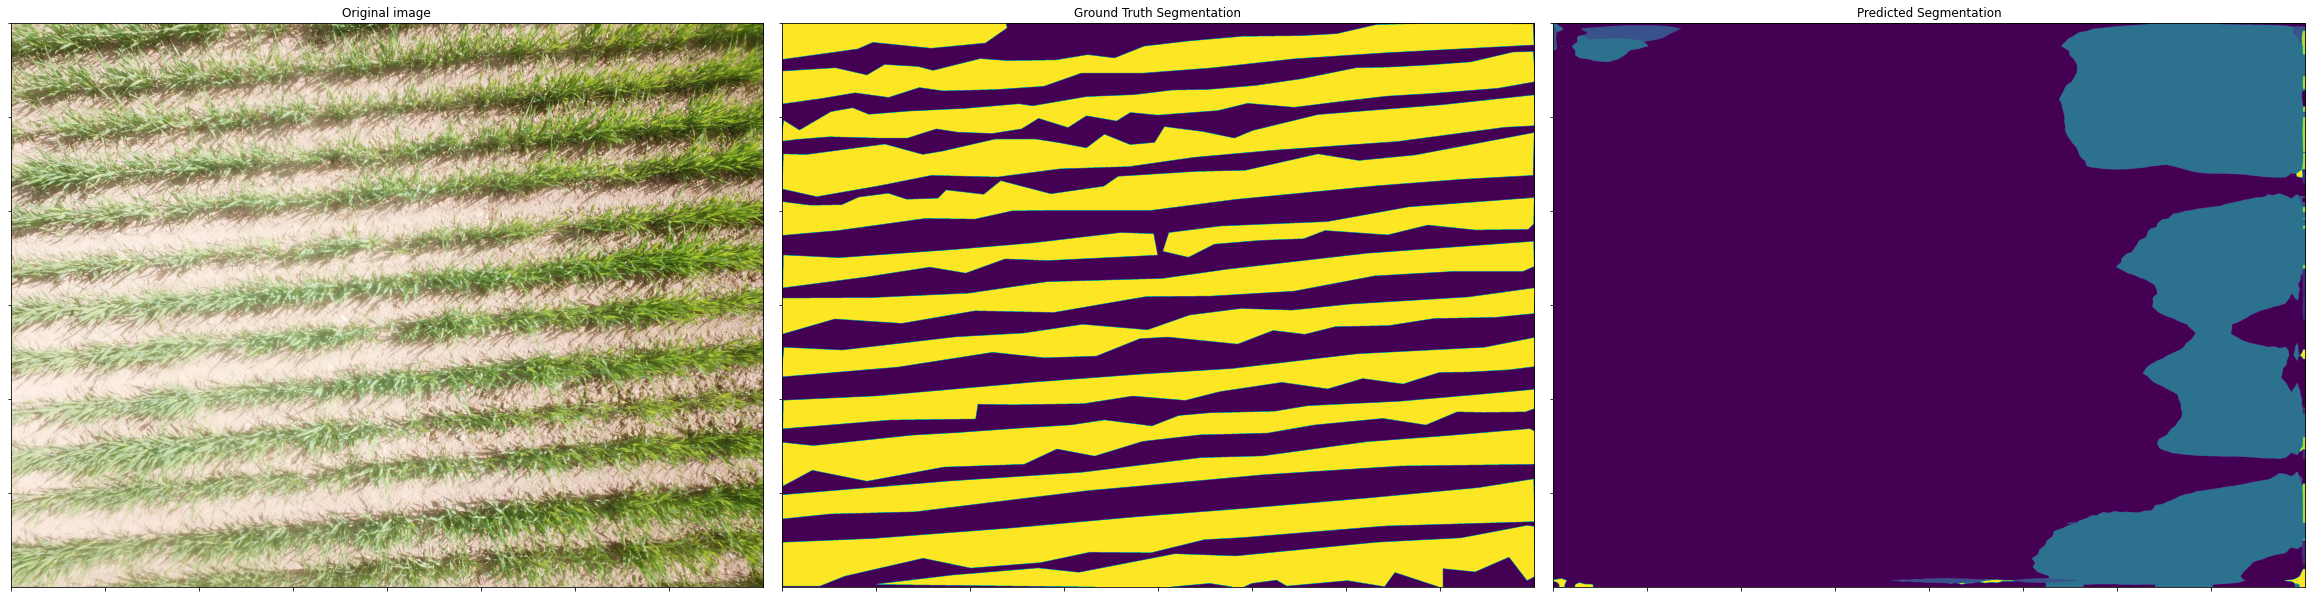

In [17]:
from PIL import Image

index = 7
ori_image = Image.open(test_files[index])

gt_seg = Image.open(test_targets[index])
# gt_seg, _, _ = gt_seg.split()

datamodule = SemanticSegmentationData.from_files(
    predict_files=[
        test_files[index],
    ],
    batch_size=3,
)
predictions = trainer.predict(model, datamodule=datamodule, output="preds")

pred_0 = predictions[0][0]
pred_seg = np.argmax(pred_0, axis=0)
print(pred_seg.unique())
image_names = ["Original image", "Ground Truth Segmentation", "Predicted Segmentation"]
image_arrays = [ori_image, gt_seg, pred_seg]
display_images(nrow=1, ncol=3, image_names=image_names, image_arrays=image_arrays, fig_name='resnet50-unetplusplus.png')